In [145]:
from PyDakota.regression import *
from PyDakota.models.genz import GenzFunction
from PyDakota.approximation import *

num_vars = 2
variables = BoundedVariables()
ranges = define_homogeneous_ranges(num_vars, 0., 1.);
variables.set_ranges(ranges)

function = GenzFunction('oscillatory',num_vars)
function.set_coefficients(10., 'no-decay')

var_transform = AffineVariableTransformation()
var_transform.set_variables(variables)

from PyDakota.math_tools import compute_hyperbolic_indices
degree = 20
approx = Monomial()
approx.set_variable_transformation(var_transform)
basis_indices = compute_hyperbolic_indices(num_vars, degree, 1.)
approx.set_basis_indices(basis_indices)

from PyDakota.math_tools import qr_solve, NO_TRANS
num_training_samples = 100#2*basis_indices.shape[1]
training_samples = numpy.random.uniform(0,1,(num_vars,num_training_samples))
function_opts = {'eval_type':'value-grad'}
training_function_vals = function.value(training_samples,function_opts)
basis_matrix = approx.generate_basis_matrix(training_samples)


In [150]:
num_folds = 10
regression_type = LASSO_REGRESSION#ORTHOG_MATCH_PURSUIT
cv_opts = {'num-points':num_training_samples,'num-folds':num_folds}
regression_opts = {'verbosity':0,'cv-opts':cv_opts}
cv_solver = CrossValidatedSolver()
cv_solver.set_linear_system_solver(regression_type)
cv_solver.solve(basis_matrix, training_function_vals, regression_opts)
solutions = cv_solver.get_final_solutions()
scores = cv_solver.get_best_scores()
cv_iterator = cv_solver.get_cross_validation_iterator()
cv_iterator = cast_to_linear_system_cross_validation_iterator(cv_iterator)
cv_scores = cv_iterator.get_scores()
cv_residuals = cv_iterator.get_unique_tolerances()
print "Cross validation error:",scores

Cross validation error: [  3.74794986e-05   2.92529520e-03   2.63276564e-02]


In [163]:
num_rhs = training_function_vals.shape[1]
num_validation_samples = 100
validation_samples = numpy.random.uniform(0,1,(num_vars,num_validation_samples))
validation_function_vals = function.value(validation_samples, function_opts)
regression_opts = {'regression_type':regression_type}
solver = regression_solver_factory(regression_opts) 
solver.solve(basis_matrix, training_function_vals, regression_opts)
best_tolerances = cv_iterator.get_adjusted_best_residual_tolerances()
cv_solutions = cv_solver.get_final_solutions()
mse = []
residuals = []
for i in range(num_rhs):
    coef = solver.get_solutions_for_all_regularization_params(i)
    num_steps = coef.shape[1]
    approx.set_coefficients(coef)
    approx_validation_vals = approx.value(validation_samples)
    approx_training_vals = approx.value(training_samples)
    residuals.append(numpy.linalg.norm(numpy.tile(training_function_vals[:,i],(num_steps,1)).T-approx_training_vals,axis=0))
    numpy.tile(validation_function_vals[:,i],(num_steps,1)).T.shape
    mse.append(1./num_validation_samples*numpy.linalg.norm(numpy.tile(validation_function_vals[:,i],(num_steps,1)).T-approx_validation_vals,axis=0)**2)
    
approx.set_coefficients(cv_solutions)
cv_approx_validation_vals = approx.value(validation_samples)
cv_approx_training_vals = approx.value(training_samples)
cv_solution_residuals = numpy.linalg.norm(training_function_vals-cv_approx_training_vals,axis=0)
cv_approx_mse = 1./num_validation_samples*numpy.linalg.norm(validation_function_vals-cv_approx_validation_vals,axis=0)**2
    

In [152]:
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['text.usetex'] = True # use latex for all text handling
mpl.rcParams['savefig.bbox'] = 'tight'
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.labelsize'] = 20
plt.rcParams['text.latex.preamble'] = [r'\usepackage{siunitx}', r'\usepackage{amsmath}']

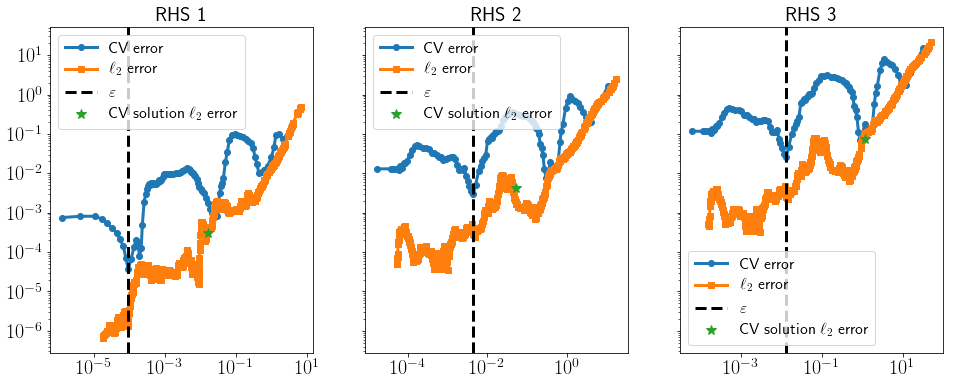

In [166]:
f,axs=pylab.subplots(1,num_rhs,sharey=True,figsize=(16, 6))
axs = axs.ravel()
for i in range(num_rhs):
    axs[i].loglog(cv_residuals[i]/.9,cv_scores[i],'-o',label='CV error')
    axs[i].loglog(residuals[i],mse[i],'-s',label='$\ell_2$ error')
    axs[i].axvline(best_tolerances[i],linestyle='--',color='k',label='$\\varepsilon$')
    axs[i].loglog(cv_solution_residuals[i],cv_approx_mse[i],'*',ms=10,label='CV solution $\ell_2$ error')
    axs[i].set_title('RHS %d'%(i+1))
    axs[i].legend(fontsize=16)
    

Populating the interactive namespace from numpy and matplotlib


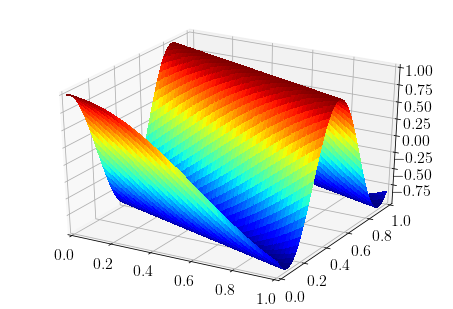

In [112]:
%pylab inline
from utilities.visualisation import plot_surface_from_function
plot_surface_from_function(function.value,[0,1,0,1])